## 회고
---

#### Point 1) TensorFlow 적응기
- Keras Tensor와 Tensor는 다르다.(Keras Tensor는 `.shape()`이란 메소드가 없다. 그래서 사용하려면 tensor 혹은 ndarray 같이 변환해줘야 했다.)
- 이외에 저번부터 시작된 TensorFlow 적응기는 파라미터 하나하나 바꿔줄 때마다 거치고 있다. 아마도 `tf.data.Dataset` 객체에 데이터 + 라벨이 같이 있을 경우 해당 모습을 이해하는 데 조금 시간이 걸린 것 같다.

#### Point 2) 논문 구현 시 실행하지 못한 점
- 이번 논문 구현에 어느 정도 자신감(?)이 붙어서 하는 김에 이것저것 구현할 수 있는 것들을 다 구현해보려 했지만, 프로젝트 진행상 너무 복잡해지는 부분이나 논문 내용 중 이해가 되지 않은 몇몇 부분들은 실행하지 못했다. 특히, 이해되지 않았던 부분들을 아래에 목록으로 정리하고, 추후 누군가 이해하는 분이 있다면 그 분의 도움을 통해 구현해보고 싶다.
- Data Augmentation 부분
  - _"the per-pixel mean subtracted"_
    - 어디서 보면 배치 이미지들의 공통 pixel의 mean이라는데 그건 좀 아닌 것 같고...
  - _"The standard color augmentation in [21] is used."_
    - 이건 참고 논문 가서 찾아보니까 PCA를 사용한 기법 같은데 잘 모르겠다...

#### Poin 3) 논문 <-> 아이펠 노드 힌트와의 다른 점...?
- 현재까지 내가 논문을 이해한 바에 따르면 아이펠 노드와는 다른 점이 한 가지 있는데 바로 **ResNet-34**에서 shortcut을 구현하는 부분이다. 
- 내가 이해하기로는 dimension이 바뀌는 부분에서 shorcut 옵션 A를 썼는데, 아이펠 노드에서는 옵션 B를 사용한 것으로 보인다.
- 내가 옵션 A라고 생각하는 이유는 논문 내 5페이지에 보면 `"In the first comparison (Table 2 and Fig. 4 right), we use identity mapping for all shortcuts and zero-padding
for increasing dimensions (option A). So they have no extra
parameter compared to the plain counterparts."`라고 ResNet-34를 지칭하며 작성된 글이 있어서인데, 사실 이외에 다른 부분에 ResNet-34의 Shortcut에 대해 정확히 어떤 것을 쓰겠다고 바꿔서 얘기한 부분이 있는지 모르겠다.(좀 뒤에 가면 옵션 A, B, C의 비교 부분이 있지만, 거기서도 정확하게 B를 쓰겠다고 한 것은 없는 것 같다.)
- 사실 다른 블로그들을 보면 아이펠 노드와 같은 방식으로 구현하려 하지만, 어떠한 이유에서 옵션 B를 사용했다는지 구체적인 근거를 찾기가 어렵다.
- 어쩌면 이 부분은 그냥 옵션 A, B, C 테스트 결과를 보여주는 것으로서의 의미가 있을 뿐 **'ResNet-34는 꼭 이래야 합니다!'**는 아니어서 각자의 재량껏 구현하면 되는 것일까?
- 여튼 논문 구현에서 정확히 밝혀지지 않은 부분에 대한 논쟁(?)과 그것을 해결하기 위해 노력한 점이 이번 프로젝트 진행하며 얻게 된 또 하나의 값진 경험인 듯하다.(그런데 나중에 살펴보니까 ResNet-50에 대해서도 여기저기서 구현한 모델이 조금씩 다른 것 같다.)

## 프로젝트: ResNet Ablation Study

#### 배경
- VGG-16, 19의 모델을 구현해봤다.
- ResNet 원리에 대한 이해가 있으며, 논문의 내용을 실제로 구현해보려 한다.

### 1) 라이브러리 버전 확인
---

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### 2) ResNet 기본 블록 구성하기
---
- 여러번 반복되는 주요 구조를 모듈화 시켜서 단순 숫자만 바꿔서 모델 내에 구성할 수 있도록 준비한다.

#### Subset 블록들과 유틸리티(?) 함수 정의

In [2]:
# 모델 앞단의 layer subset
def resnet_front(x):
    # Conv 레이어
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same', strides=2, kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # MaxPooling 레이어
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)
    return x

# 모델 뒷단의 layer subset
def resnet_end(inputs, num_classes):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    if num_classes == 2:
        x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    elif num_classes > 2:
        x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return x

# 제일 작은 단위의 layer subset 만들기
def conv_bn_relu(inputs, strides, num_channel,kernel_size=3, padding='same'):
    x = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x 

# shortcut에 사용할 downsample + zero_pad
def maxpool_zeropad(inputs, num_channel):
    """
    shortcut 중 채널 수가 증가하는 레이어에 대한 논문 내 A 방법
    """
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(inputs)
    diff = num_channel - tf.convert_to_tensor(x).shape[-1]
    x = tf.pad(x, [[0,0], [0,0], [0,0], [0, diff]]) # 원래 채널 수만큼 뒤에 더 붙이는 것이니 이렇게 구현
    return x


> **note**:
> - 위의 `maxpool_zeropad` 함수는 shortcut 구현 방법 중 옵션 A를 위해 만든 함수인데, 이번 노트북에서는 사용하지 않았다.

#### ResNet-34에 쓰이는 공통 블록 만들기

In [3]:
def resnet_34_block(initial_input, num_channel, num_layers, is_downsample:bool, is_shortcut:bool):
    
    # 인풋 받기
    x = initial_input
    
    # 블록 첫 단위에 downsample 필요한 경우, Residual Net인 경우 bool 값으로만 받기
    assert type(is_downsample) == bool
    assert type(is_shortcut) == bool

    # Plain Network
    if not is_shortcut:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x = conv_bn_relu(x, strides=2, num_channel=num_channel)
            x = conv_bn_relu(x, strides=1, num_channel=num_channel)

            # 나머지 블록들
            for _ in range(num_layers - 1):
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)

        # downsample 안 하는 레이어 그룹이면,
        else:
            for _ in range(num_layers):
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)

    # Residual Network
    else:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x_preserved = x # shortcut을 위해 보존
            x = conv_bn_relu(x, strides=2, num_channel=num_channel)
            x = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=3, padding='same', strides=1, kernel_initializer='he_normal')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x_preserved = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=1, padding='same', strides=2, kernel_initializer='he_normal')(x_preserved)
            x_preserved = tf.keras.layers.BatchNormalization()(x_preserved)
            x += x_preserved
            x = tf.keras.layers.ReLU()(x)

            # downsample 안 하는 나머지 블록들
            for _ in range(num_layers - 1):
                x_preserved = x # shortcut을 위해 보존
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)
                x = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=3, padding='same', strides=1, kernel_initializer='he_normal')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x += x_preserved # shortcut 합치기
                x = tf.keras.layers.ReLU()(x)     

        # downsample 안 하는 레이어 그룹이면,
        else:
            for _ in range(num_layers):
                x_preserved = x # shortcut을 위해 보존
                x = conv_bn_relu(x, strides=1, num_channel=num_channel)
                x = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=3, padding='same', strides=1, kernel_initializer='he_normal')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x += x_preserved # shortcut 합치기
                x = tf.keras.layers.ReLU()(x)
    return x

In [4]:
# 블록 테스트
test_list = [[True, True], [True, False], [False, True], [False, False]]

initial_inputs = tf.keras.Input((32, 32, 3))

for i, choices in enumerate(test_list):
    if i < 2:
        outputs = resnet_34_block(initial_inputs, num_channel=64, num_layers=3, is_downsample=choices[0], is_shortcut=choices[1])
        t_model = tf.keras.Model(inputs=initial_inputs, outputs=outputs)
        print(f" {i+1}번째 조합 성공")
    else:
        # Downsample이 False일 경우 입력 텐서의 채널 수와 같아야 하기 때문에 해당 조합들은
        # num_channel=3으로 맞춰줌
        outputs = resnet_34_block(initial_inputs, num_channel=3, num_layers=3, is_downsample=choices[0], is_shortcut=choices[1])
        t_model = tf.keras.Model(inputs=initial_inputs, outputs=outputs)
        print(f" {i+1}번째 조합 성공")

# 마지막 조합 블록 테스트      
t_model.summary()

 1번째 조합 성공
 2번째 조합 성공
 3번째 조합 성공
 4번째 조합 성공
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 3)         84        
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 32, 32, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 3)         84        
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 3)        12        
 chNormalizatio

### 3) ResNet-34 모델 구현
---
- 개인적으로 한 함수를 통해 `ResNet-34`와 `ResNet-50` 구현을 조정할 수 있게 하는 것보다 `ResNet`과 `Plain`을 조정할 수 있게 하는 게 더 직관적일 것 같아서 그렇게 구현했다.

In [5]:
# 모델 생성 함수
def build_34_model(input_shape, is_shortcut, num_classes=10):
    initial_inputs = tf.keras.layers.Input(input_shape)
    x = resnet_front(initial_inputs)
    x = resnet_34_block(x, num_channel=64, num_layers=3, is_downsample=False, is_shortcut=is_shortcut)
    x = resnet_34_block(x, num_channel=128, num_layers=4, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_34_block(x, num_channel=256, num_layers=6, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_34_block(x, num_channel=512, num_layers=3, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_end(x, num_classes=num_classes)
    
    model = tf.keras.Model(inputs=initial_inputs, outputs=x)
    return model

In [6]:
# 모델 만들기
resnet_34 = build_34_model((32, 32, 3), is_shortcut=True)
resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 16, 16, 64)  256         ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_24 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_25[0]

### 4) ResNet-50 모델 구현
---


#### 추가되는 ResNet-50 블록 함수 만들기
- ResNet-50의 경우 `conv-BN-relu` 조합의 **post-activation**과 `BN-relu-conv` 조합의 **pre-activation** 조합이 있는데, 어쩌다 보니 두 경우 다 구현하게 되었다.

In [7]:
# post-activation 버전
def resnet_50_block_post_act(initial_input, num_channel:list, num_layers, is_downsample:bool, is_shortcut:bool):
    
    # 인풋 받기
    x = initial_input
    
    # 블록 첫 단위에 downsample 필요한 경우, Residual Net인 경우 bool 값으로만 받기
    assert type(is_downsample) == bool
    assert type(is_shortcut) == bool
    assert type(num_channel) == list    

    # Plain Network
    if not is_shortcut:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x = conv_bn_relu(x, strides=2, num_channel=num_channel[0], kernel_size=1)
            x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
            x = conv_bn_relu(x, strides=1, num_channel=num_channel[2], kernel_size=1)

            # 나머지 블록들
            for i in range(num_layers - 1):
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[2], kernel_size=1)

        # downsample 안 하는 레이어 그룹이면,
        else:
            for i in range(num_layers):
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[2], kernel_size=1)

    # Residual Network
    else:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x_preserved = x # shortcut을 위해 보존
            x = conv_bn_relu(x, strides=2, num_channel=num_channel[0], kernel_size=1)
            x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
            x = tf.keras.layers.Conv2D(filters=num_channel[2], strides=1, kernel_size=1, padding='same', kernel_initializer='he_normal')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            if x_preserved.shape[-1] != x.shape[-1]:
                x_preserved = tf.keras.layers.Conv2D(filters=num_channel[2], kernel_size=1, padding='same', strides=2, kernel_initializer='he_normal')(x_preserved)
                x_preserved = tf.keras.layers.BatchNormalization()(x_preserved)
            x += x_preserved
            x = tf.keras.layers.ReLU()(x)

            # downsample 안 하는 나머지 블록들
            for i in range(num_layers - 1):
                x_preserved = x # shortcut을 위해 보존
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = tf.keras.layers.Conv2D(filters=num_channel[2], strides=1, kernel_size=1, padding='same', kernel_initializer='he_normal')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                if x_preserved.shape[-1] != x.shape[-1]:
                    x_preserved = tf.keras.layers.Conv2D(filters=num_channel[2], kernel_size=1, padding='same', strides=1, kernel_initializer='he_normal')(x_preserved)
                    x_preserved = tf.keras.layers.BatchNormalization()(x_preserved)
                x += x_preserved
                x = tf.keras.layers.ReLU()(x)  

        # downsample 안 하는 레이어 그룹이면,
        else:
            for i in range(num_layers):
                x_preserved = x # shortcut을 위해 보존
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = conv_bn_relu(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = tf.keras.layers.Conv2D(filters=num_channel[2], strides=1, kernel_size=1, padding='same', kernel_initializer='he_normal')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                if x_preserved.shape[-1] != x.shape[-1]:
                    x_preserved = tf.keras.layers.Conv2D(filters=num_channel[2], kernel_size=1, padding='same', strides=1, kernel_initializer='he_normal')(x_preserved)
                    x_preserved = tf.keras.layers.BatchNormalization()(x_preserved)
                x += x_preserved
                x = tf.keras.layers.ReLU()(x)  
    return x

In [8]:
# 블록 테스트
test_list = [[True, True], [True, False], [False, True], [False, False]]

initial_inputs = tf.keras.Input((32, 32, 3))

for i, choices in enumerate(test_list):
    if i < 2:
        outputs = resnet_50_block_post_act(initial_inputs, num_channel=[64, 64, 128], num_layers=3, is_downsample=choices[0], is_shortcut=choices[1])
        t_model = tf.keras.Model(inputs=initial_inputs, outputs=outputs)
        print(f" {i+1}번째 조합 성공")
    else:
        # Downsample이 False일 경우 입력 텐서의 채널 수와 같아야 하기 때문에 해당 조합들은
        # num_channel 첫번째를 인풋과 같이 3으로 맞춰줌
        outputs = resnet_50_block_post_act(initial_inputs, num_channel=[3, 64, 128], num_layers=3, is_downsample=choices[0], is_shortcut=choices[1])
        t_model = tf.keras.Model(inputs=initial_inputs, outputs=outputs)
        print(f" {i+1}번째 조합 성공")

# 마지막 조합 블록 테스트      
t_model.summary()

 1번째 조합 성공
 2번째 조합 성공
 3번째 조합 성공
 4번째 조합 성공
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_90 (Conv2D)          (None, 32, 32, 3)         12        
                                                                 
 batch_normalization_90 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 re_lu_84 (ReLU)             (None, 32, 32, 3)         0         
                                                                 
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_91 (Bat  (None, 32, 32, 64)       256       
 chNormalizatio

In [9]:
def build_50_model_post_act(input_shape, is_shortcut, num_classes=10):
    initial_inputs = tf.keras.layers.Input(input_shape)
    x = resnet_front(initial_inputs)
    x = resnet_50_block_post_act(x, num_channel=[64, 64, 256], num_layers=3, is_downsample=False, is_shortcut=is_shortcut)
    x = resnet_50_block_post_act(x, num_channel=[128, 128, 512], num_layers=4, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_50_block_post_act(x, num_channel=[256, 256, 1024], num_layers=6, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_50_block_post_act(x, num_channel=[512, 512, 2048], num_layers=3, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_end(x, num_classes=num_classes)
    
    model = tf.keras.Model(inputs=initial_inputs, outputs=x)
    return model

In [10]:
resnet_50_post = build_50_model_post_act((32, 32, 3), True)
resnet_50_post.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_99 (Conv2D)             (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_99 (BatchN  (None, 16, 16, 64)  256         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_93 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_99[0]

##### pre-activation 사용 버전

In [11]:
# 제일 작은 단위의 layer subset 만들기
# pre-activation 사용
def bn_relu_conv(inputs, strides, num_channel,kernel_size=3, padding='same'):
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=num_channel, kernel_size=kernel_size, padding=padding, strides=strides, kernel_initializer='he_normal')(x)
    return x 

In [12]:
# pre-activation 사용
def resnet_50_block_pre_act(initial_input, num_channel:list, num_layers, is_downsample:bool, is_shortcut:bool):
    
    # 인풋 받기
    x = initial_input
    
    # 블록 첫 단위에 downsample 필요한 경우, Residual Net인 경우 bool 값으로만 받기
    assert type(is_downsample) == bool
    assert type(is_shortcut) == bool
    assert type(num_channel) == list    

    # Plain Network
    if not is_shortcut:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x = bn_relu_conv(x, strides=2, num_channel=num_channel[0], kernel_size=1)
            x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
            x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)

            # 나머지 블록들
            for i in range(num_layers - 1):
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)

        # downsample 안 하는 레이어 그룹이면,
        else:
            for i in range(num_layers):
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)

    # Residual Network
    else:
        
        # downsample 하는 레이어 그룹이면,
        if is_downsample:
            
            # downsample 하는 첫번째 블록
            x_preserved = x # shortcut을 위해 보존
            x = bn_relu_conv(x, strides=2, num_channel=num_channel[0], kernel_size=1)
            x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
            x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)
            if x_preserved.shape[-1] != x.shape[-1]:
                x_preserved = bn_relu_conv(x_preserved, strides=2, num_channel=num_channel[2], kernel_size=1)
            x += x_preserved

            # downsample 안 하는 나머지 블록들
            for i in range(num_layers - 1):
                x_preserved = x # shortcut을 위해 보존
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)
                if x_preserved.shape[-1] != x.shape[-1]:
                    x_preserved = bn_relu_conv(x_preserved, strides=1, num_channel=num_channel[2], kernel_size=1)
                x += x_preserved

        # downsample 안 하는 레이어 그룹이면,
        else:
            for i in range(num_layers):
                x_preserved = x # shortcut을 위해 보존
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[0], kernel_size=1)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[1], kernel_size=3)
                x = bn_relu_conv(x, strides=1, num_channel=num_channel[2], kernel_size=1)
                if x_preserved.shape[-1] != x.shape[-1]:
                    x_preserved = bn_relu_conv(x_preserved, strides=1, num_channel=num_channel[2], kernel_size=1)
                x += x_preserved  
    return x

In [13]:
def build_50_model_pre_act(input_shape, is_shortcut, num_classes=10):
    initial_inputs = tf.keras.layers.Input(input_shape)
    x = resnet_front(initial_inputs)
    x = resnet_50_block_pre_act(x, num_channel=[64, 64, 256], num_layers=3, is_downsample=False, is_shortcut=is_shortcut)
    x = resnet_50_block_pre_act(x, num_channel=[128, 128, 512], num_layers=4, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_50_block_pre_act(x, num_channel=[256, 256, 1024], num_layers=6, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_50_block_pre_act(x, num_channel=[512, 512, 2048], num_layers=3, is_downsample=True, is_shortcut=is_shortcut)
    x = resnet_end(x, num_classes=num_classes)
    
    model = tf.keras.Model(inputs=initial_inputs, outputs=x)
    return model

In [14]:
resnet_50_pre = build_50_model_pre_act((32, 32, 3), is_shortcut=True)
resnet_50_pre.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_152 (Conv2D)            (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_152 (Batch  (None, 16, 16, 64)  256         ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_142 (ReLU)               (None, 16, 16, 64)   0           ['batch_normalization_152[

### 4) Plain 모델 구현
---

- 앞에서 구현한 함수에서 `is_shortcut=False` 파라미터 지정을 통해 plain 모델을 구현한다.

In [15]:
# plain_34
plain_34 = build_34_model((32, 32, 3), is_shortcut=False)
plain_34.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_205 (Conv2D)         (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_205 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 re_lu_195 (ReLU)            (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_206 (Conv2D)         (None, 8, 8, 64)          369

> **note**:
> - plain_50 모델은 논문에서 중점적으로 얘기한 pre-activation을 사용해서 비교해본다.

In [16]:
plain_50_pre = build_50_model_pre_act((32, 32, 3), is_shortcut=False)
plain_50_pre.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_238 (Conv2D)         (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_238 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 re_lu_228 (ReLU)            (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_239 (Ba  (None, 8, 8, 64)         256

### 5) 데이터 불러오기
---
- `(224, 224, 3)` 크기의 이미지 사용을 위해 `cats_vs_dogs` 데이터를 사용해본다.

In [17]:
import tensorflow_datasets as tfds

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
    )

In [18]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [19]:
print(f"Train : {tf.data.experimental.cardinality(ds_train)}")
print(f"Val   : {tf.data.experimental.cardinality(ds_val)}")
print(f"Test  : {tf.data.experimental.cardinality(ds_test)}")

Train : 18610
Val   : 2326
Test  : 2326


In [20]:
# 이미지 크기 확인
for datum in ds_train.take(1):
    break

print(tf.shape(datum[0]))

tf.Tensor([445 471   3], shape=(3,), dtype=int32)


> **note**:
> - 논문과 최대한 비슷하게 Data Augmentation을 구현할 예정이다._(3.4 Implementation 부분 참고)_
> - 이미지에 `random_crop`을 사용하기 위해 사이즈는 (250, 250, 3)으로 리사이즈하고, (224, 224, 3)으로 crop할 예정이고, 추가적으로 그 전후로 좌우반전과 정규화 부분을 넣었다. 

In [21]:
# 전처리 함수
def preprocess(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.resize(img, (250, 250))
    img = tf.image.random_crop(img, size=(224, 224, 3))
    img = tf.math.divide(img, 255) # Normalise
    return img, label

In [22]:
# 데이터셋 만들기
ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

In [23]:
# shape 잘 나왔는지 확인
for a in ds_train.take(1):
    break
tf.shape(a[0])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([128, 224, 224,   3], dtype=int32)>

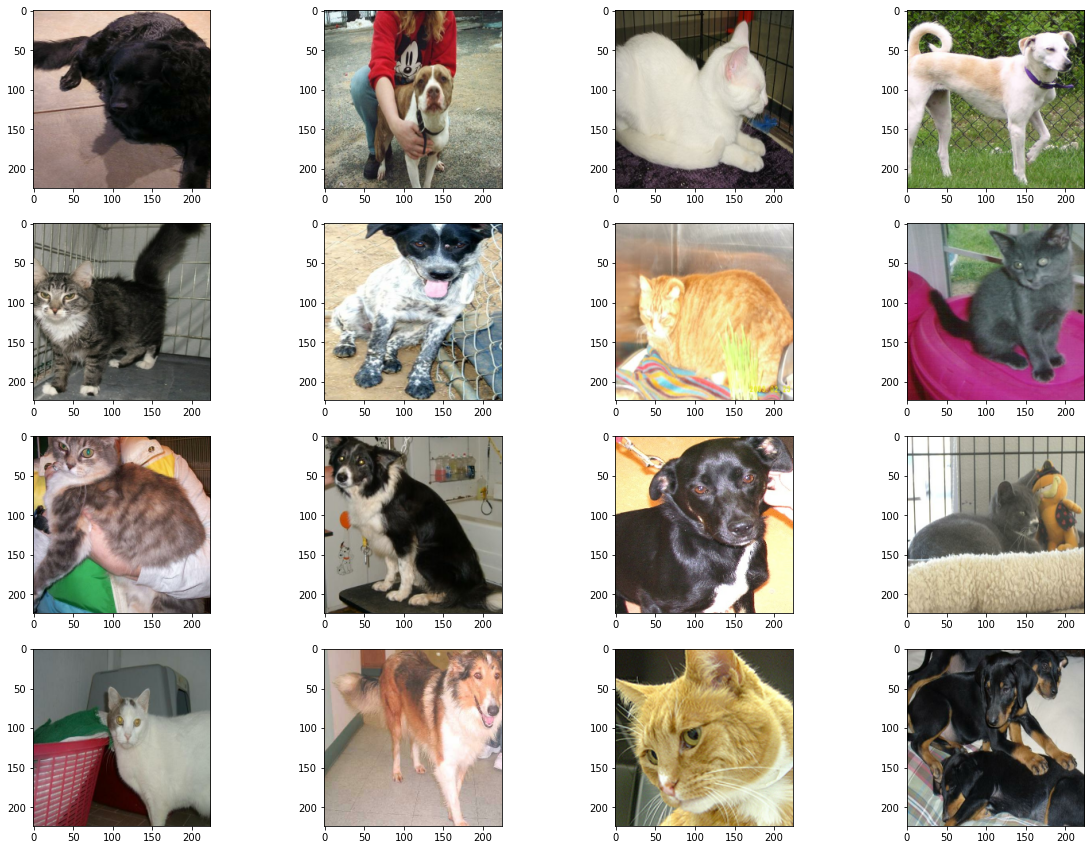

In [24]:
# 데이터셋 Augmentation 적용 확인
import matplotlib.pyplot as plt

for mini_batch in ds_train.take(1):
    break

plt.figure(figsize=(20, 15))

for idx, img in enumerate(mini_batch[0]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(img)
    if idx == 15:
        break

plt.show()


### 6) 모델 컴파일 및 학습
---
- 논문에서는 SGD를 활용한 Adaptive learning rate method를 구현하는 것 같은데, 이미 Adam으로 비슷한 구조가 구현되어 있는 것 같아서 Adam을 사용하는데, weight-decay를 적용할 수 있는 `tfa.optimizers.AdamW`라는 API를 사용해볼 예정이다.
  - _**해당 부분은 실험 결과 그냥 Adam이 더 수월한 것 같아서 밑에 주석처리해놓음**_
  - 그리고 처음에는 30 epoch로 했지만 너무 긴 것 같아서 20 epoch로 변경했다.
  - 중간에 OOM 오류가 나서 배치 사이즈도 128로 변경했다.

In [25]:
# 수정된 input shape에 맞게 모델을 다시 생성한다.
resnet_34 = build_34_model((224, 224, 3), is_shortcut=True, num_classes=2)
plain_34 = build_34_model((224, 224, 3), is_shortcut=False, num_classes=2)
resnet_50_post = build_50_model_post_act((224, 224, 3), is_shortcut=True, num_classes=2)
resnet_50_pre = build_50_model_pre_act((224, 224, 3), is_shortcut=True, num_classes=2)
plain_50_pre = build_50_model_pre_act((224, 224, 3), is_shortcut=False, num_classes=2)

models = [resnet_34, plain_34, resnet_50_post, resnet_50_pre, plain_50_pre]

# resnet_50_pre만 summary로 확인해보기
resnet_50_pre.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_409 (Conv2D)            (None, 112, 112, 64  9472        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_409 (Batch  (None, 112, 112, 64  256        ['conv2d_409[0][0]']             
 Normalization)                 )                                                          

In [26]:
!pip install tensorflow_addons

In [27]:
# # 모델 전체 컴파일하기
# import tensorflow_addons as tfa

# # learning_rate schedule 설정
# # 논문에서는 Adaptive한 것을 요구한 것 같은데,
# # decay_step과 decay_rate으로 여기는 fix함
# initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.90,
#     staircase=True)

# # optimizer 설정
# # weight_decay는 논문에서 제시한 숫자를 넣어봤음
# optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule,
#                                  weight_decay=0.0001)


# # 전체 컴파일
# for model in models:
#     model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

# # 체크포인트 설정
# # 경로 설정
# from google.colab import drive
# drive.mount('/content/drive')

# checkpoint_filepath = '/content/drive/My Drive/Aiffel/GD_02/checkpoint/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)    

In [28]:
# # 조건 설정
# EPOCHS = 40
# BATCH_SIZE = 256

In [29]:
# # 학습하기
# # 1. ResNet-34

# history_1 = resnet_34.fit(ds_train,
#               epochs=EPOCHS,
#               batch_size=BATCH_SIZE,
#               validation_data=ds_val,
#               verbose=1,
#               use_multiprocessing=True,
#               callbacks=[model_checkpoint_callback])

In [30]:
# EPOCHS = 30

In [31]:
# # 비교할 모델 생성
# resnet_34_adam = build_34_model((224, 224, 3), is_shortcut=True, num_classes=2)

# resnet_34_adam.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# # 체크포인트 설정
# # 경로 설정
# import os

# checkpoint_filepath = '/content/drive/My Drive/Aiffel/GD_02/resnet_34_adam'
# if not os.path.exists(checkpoint_filepath):
#     os.makedirs(checkpoint_filepath)

# checkpoint_filepath = checkpoint_filepath + '/checkpoint'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# history_2 = resnet_34_adam.fit(ds_train,
#               epochs=EPOCHS,
#               batch_size=BATCH_SIZE,
#               validation_data=ds_val,
#               verbose=1,
#               use_multiprocessing=True,
#               callbacks=[model_checkpoint_callback])

##### 중간에 학습 끊겼던 모델 불러와서 측정해보기

In [32]:
# 경로 설정
from google.colab import drive
drive.mount('/content/drive')

checkpoint_filepath = '/content/drive/My Drive/Aiffel/GD_02/checkpoint/checkpoint'
checkpoint_filepath_adam = '/content/drive/My Drive/Aiffel/GD_02/resnet_34_adam/checkpoint'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# 모델 생성 및 훈련된 파라미터 불러오기
resnet_34_adam = build_34_model((224, 224, 3), is_shortcut=True, num_classes=2)

resnet_34.load_weights(checkpoint_filepath)
resnet_34_adam.load_weights(checkpoint_filepath_adam)

In [34]:
# training error 확인
# resnet_34
prediction_1 = resnet_34.predict(ds_train)

y_pred = np.argmax(prediction_1, axis=1)
y_true = np.concatenate([y for x, y in ds_train], axis=0)

training_error = 1 - np.sum(y_true == y_pred) / len(y_true)
training_error

0.5020956475013434

> **note**:
> - dataset 에서 shuffle이 되어서 그런지 뭔가 training error 수치가 아닌 것 같다...;;
> - 다시 `evaluate`을 통해 train 셋에 확인해보자.

In [35]:
# Accuracy 확인
# evaluate 을 쓰기 위해 기존에 진행했던 포맷으로 compile 진행
import tensorflow_addons as tfa

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.90,
    staircase=True)

# optimizer 설정
optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule,
                                 weight_decay=0.0001)

# compile
resnet_34.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

# train 셋에 대한 예측
loss, acc = resnet_34.evaluate(ds_train, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

146/146 - 32s - loss: 0.1319 - accuracy: 0.9467 - 32s/epoch - 219ms/step
Restored model, accuracy: 94.67%


> **note**:
> - 뭔가 아닌 것 같아서 해당 부분은 그냥 코드 기록용으로만 남긴다.
> - Ablation Study는 밑에서부터 시작한다.

##### Ablation Study

In [37]:
# EPOCH 변경
EPOCHS = 20
BATCH_SIZE = 128

# 모델 재생성
resnet_34 = build_34_model((224, 224, 3), is_shortcut=True, num_classes=2)
plain_34 = build_34_model((224, 224, 3), is_shortcut=False, num_classes=2)
resnet_50_post = build_50_model_post_act((224, 224, 3), is_shortcut=True, num_classes=2)
resnet_50_pre = build_50_model_pre_act((224, 224, 3), is_shortcut=True, num_classes=2)
plain_50_pre = build_50_model_pre_act((224, 224, 3), is_shortcut=False, num_classes=2)

models = [resnet_34, plain_34, resnet_50_post, resnet_50_pre, plain_50_pre]

In [38]:
# 모델별로 컴파일 다시 하기
import os 

history_list = []

for model in models:
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # 체크포인트 생성
    checkpoint_filepath = f'/content/drive/My Drive/Aiffel/GD_02/{model}'
    if not os.path.exists(checkpoint_filepath):
        os.makedirs(checkpoint_filepath)

    checkpoint_filepath = checkpoint_filepath + '/checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    
    # 훈련
    history = model.fit(ds_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=ds_val,
              verbose=1,
              use_multiprocessing=True,
              callbacks=[model_checkpoint_callback])
    print("================================================================================================")
    print(f"{model} training ended   ======================================================================")
    print("================================================================================================")
    history_list.append(history)

Epoch 1/20
146/146 [==============================] - 58s 365ms/step - loss: 0.7223 - accuracy: 0.6346 - val_loss: 0.7732 - val_accuracy: 0.5279
Epoch 2/20
146/146 [==============================] - 53s 362ms/step - loss: 0.5218 - accuracy: 0.7434 - val_loss: 0.6906 - val_accuracy: 0.6414
Epoch 3/20
146/146 [==============================] - 53s 361ms/step - loss: 0.4403 - accuracy: 0.7946 - val_loss: 2.2359 - val_accuracy: 0.5340
Epoch 4/20
146/146 [==============================] - 51s 351ms/step - loss: 0.3584 - accuracy: 0.8426 - val_loss: 2.6824 - val_accuracy: 0.5378
Epoch 5/20
146/146 [==============================] - 52s 358ms/step - loss: 0.3051 - accuracy: 0.8692 - val_loss: 0.5822 - val_accuracy: 0.7880
Epoch 6/20
146/146 [==============================] - 54s 371ms/step - loss: 0.2526 - accuracy: 0.8936 - val_loss: 0.5260 - val_accuracy: 0.8061
Epoch 7/20
146/146 [==============================] - 52s 358ms/step - loss: 0.2177 - accuracy: 0.9124 - val_loss: 0.2457 - val_ac

### 7) 학습 과정 시각화
---
- 논문과 같이 plain 모델에 비해 shortcut을 가진 resnet 모델이 더 좋은 validation loss 수렴 모습을 보여줬는지 확인한다.
- 또한 같은 shortcut을 가진 모델이라면, 더 깊은 모델인 resnet-50이 resnet-34보다 더 나은 validation accuracy를 보여주는지 확인한다.

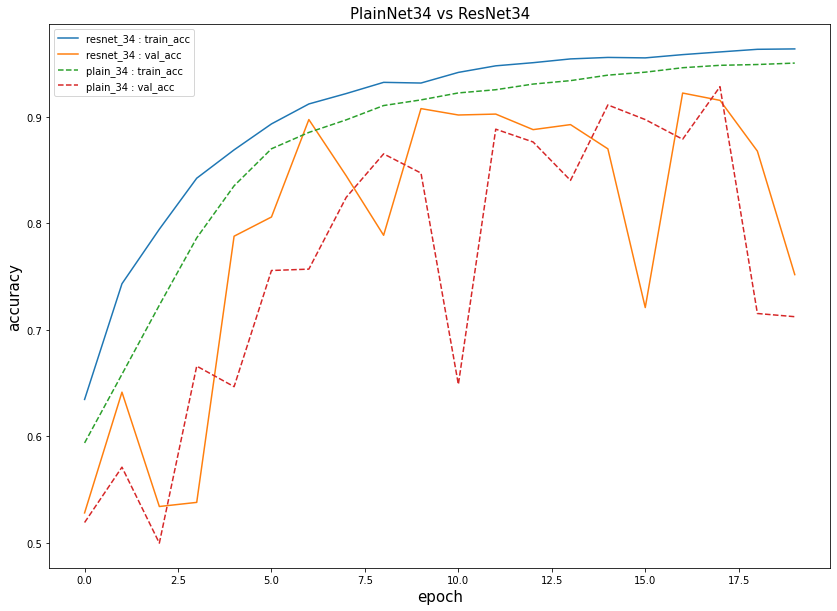

In [45]:
# ResNet34 vs Plain34
plt.figure(figsize=(14, 10))

plt.plot(history_list[0].history['accuracy'], label='resnet_34 : train_acc')
plt.plot(history_list[0].history['val_accuracy'], label='resnet_34 : val_acc')

plt.plot(history_list[1].history['accuracy'], label='plain_34 : train_acc', linestyle='--')
plt.plot(history_list[1].history['val_accuracy'], label='plain_34 : val_acc', linestyle='--')

plt.title('PlainNet34 vs ResNet34', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend()
plt.show()

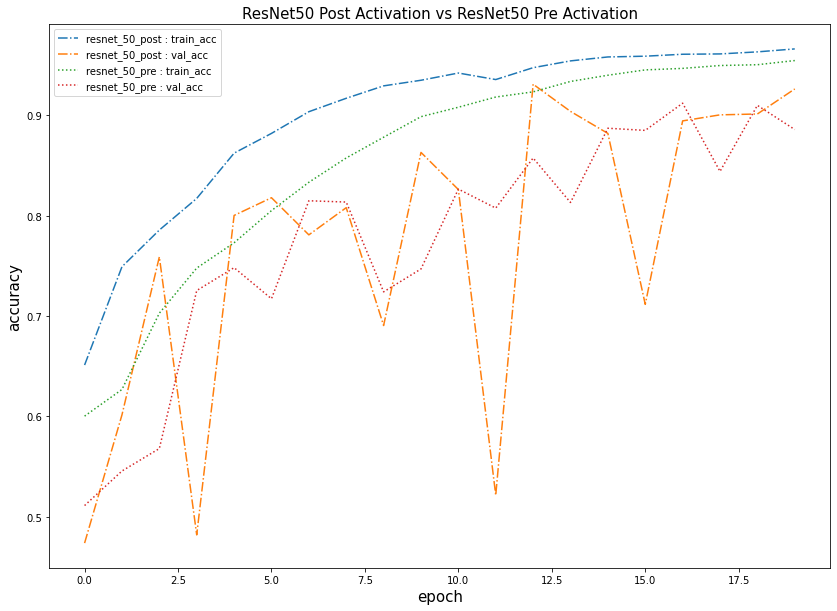

In [43]:
# ResNet50 post activation vs ResNet50 pre activation
plt.figure(figsize=(14, 10))

plt.plot(history_list[2].history['accuracy'], label='resnet_50_post : train_acc', linestyle='-.')
plt.plot(history_list[2].history['val_accuracy'], label='resnet_50_post : val_acc', linestyle='-.')

plt.plot(history_list[3].history['accuracy'], label='resnet_50_pre : train_acc', linestyle=':')
plt.plot(history_list[3].history['val_accuracy'], label='resnet_50_pre : val_acc', linestyle=':')

plt.title('ResNet50 Post Activation vs ResNet50 Pre Activation', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend()
plt.show()

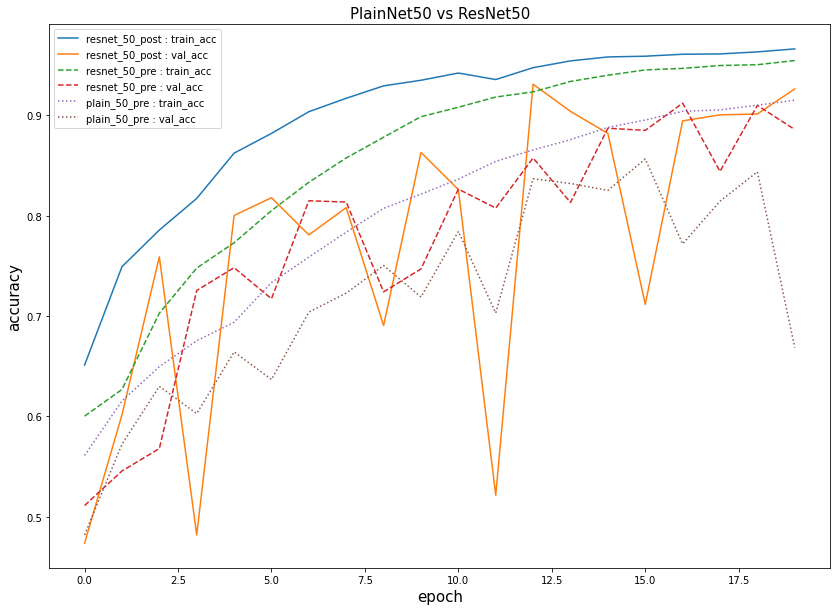

In [46]:
# ResNet50 vs Plain50
plt.figure(figsize=(14, 10))

plt.plot(history_list[2].history['accuracy'], label='resnet_50_post : train_acc')
plt.plot(history_list[2].history['val_accuracy'], label='resnet_50_post : val_acc')

plt.plot(history_list[3].history['accuracy'], label='resnet_50_pre : train_acc', linestyle='--')
plt.plot(history_list[3].history['val_accuracy'], label='resnet_50_pre : val_acc', linestyle='--')

plt.plot(history_list[4].history['accuracy'], label='plain_50_pre : train_acc', linestyle=':')
plt.plot(history_list[4].history['val_accuracy'], label='plain_50_pre : val_acc', linestyle=':')

plt.title('PlainNet50 vs ResNet50', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend()
plt.show()

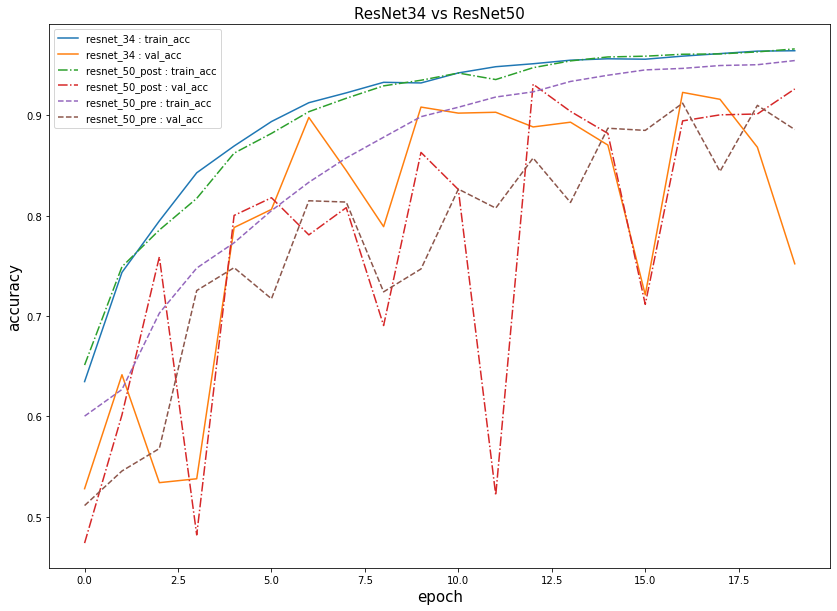

In [47]:
# ResNet34 vs ResNet50
plt.figure(figsize=(14, 10))

plt.plot(history_list[0].history['accuracy'], label='resnet_34 : train_acc')
plt.plot(history_list[0].history['val_accuracy'], label='resnet_34 : val_acc')

plt.plot(history_list[2].history['accuracy'], label='resnet_50_post : train_acc', linestyle='-.')
plt.plot(history_list[2].history['val_accuracy'], label='resnet_50_post : val_acc', linestyle='-.')

plt.plot(history_list[3].history['accuracy'], label='resnet_50_pre : train_acc', linestyle='--')
plt.plot(history_list[3].history['val_accuracy'], label='resnet_50_pre : val_acc', linestyle='--')

plt.title('ResNet34 vs ResNet50', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend()
plt.show()

##### Test 데이터에 대한 예측

In [52]:
# train 셋에 대한 예측
model_names = ['resnet_34', 'plain_34', 'resnet_50_post', 'resnet_50_pre', 'plain_50_pre']
for model, name in zip(models, model_names):
    loss, acc = model.evaluate(ds_test, verbose=2)
    print("{} model, accuracy: {:5.2f}%".format(name, 100 * acc))
    print("============================================")

19/19 - 6s - loss: 1.0069 - accuracy: 0.7777 - 6s/epoch - 321ms/step
resnet_34 model, accuracy: 77.77%
19/19 - 4s - loss: 1.0381 - accuracy: 0.7132 - 4s/epoch - 206ms/step
plain_34 model, accuracy: 71.32%
19/19 - 4s - loss: 0.1762 - accuracy: 0.9308 - 4s/epoch - 217ms/step
resnet_50_post model, accuracy: 93.08%
19/19 - 4s - loss: 0.2777 - accuracy: 0.8831 - 4s/epoch - 217ms/step
resnet_50_pre model, accuracy: 88.31%
19/19 - 4s - loss: 2.6518 - accuracy: 0.6956 - 4s/epoch - 213ms/step
plain_50_pre model, accuracy: 69.56%


> **feedback**:
> - (1) Plain vs ResNet
>   - 전반적으로 training accuracy를 비교했을 때 ResNet이 더 잘 수렴되는 것을 볼 수 있다.
>   - 그리고 ResNet34보다는 ResNet50의 경우 plain과 ResNet의 차이가 좀 더 크다.
>   - 특히, 현 상황에서 test 데이터에 대한 예측을 했을 경우, plain보다 ResNet의 정확성이 훨씬 더 높다.
> - (2) ResNet50 Pre-activation vs ResNet50 Post-activation
>   - 논문과는 다르게 Post-Activation의 training accuracy가 더 높게 나왔다.
>   - 하지만 20epoch만 돌린지라, 추세상으로 30~40epoch만 되어도 pre-activation이 더 잘 수렴하게 될 수도 있을 것 같다.
> - (3) ResNet34 vs ResNet50
>   - ResNet34보다 ResNet50이 더 높은 training accuracy를 초반부터 보여준다.
> - (4) 공통
>   - validation셋에 대한 검증은 제대로 수렴되지 않는 것이 보인다.(전부 다 형편 없다.)
>   - 그리고 20epoch만 돌린 비교적 짧은 훈련이기에, 논문에서 주장한 `깊이 증가에도 안정적인 ResNet의 훈련`같은 것은 제대로 확인하지 못한 것 같다.